# DATA

In [1]:
import numpy as np
import pandas as pd
import sklearn
import os
import pickle
import math
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from datetime import datetime
from scipy.stats import norm


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  
tf.random.set_seed(1234)

In [2]:
data = pd.read_csv('data/final_data.csv')
data.head()

,r,sigma,T,s0,k,t,asset,call,asset_greater_call,scaled_call,scaled_asset,tau,moneyness,d1,d2,delta,gamma,theta,vega,rho
0,0.05,0.05,0.1,10.0,10.0,0.0,10.000000,0.090978,True,0.009098,1.0,0.10,1.000000,0.324133,0.308322,0.627082,2.394010,-0.608243,1.197005,0.617984
1,0.05,0.05,0.1,10.0,10.0,1.0,9.977024,0.071240,True,0.007124,1.0,0.09,0.997702,0.154153,0.139153,0.561255,2.634254,-0.604191,1.179973,0.497558
2,0.05,0.05,0.1,10.0,10.0,2.0,9.979236,0.066344,True,0.006634,1.0,0.08,0.997924,0.142939,0.128797,0.556831,2.798086,-0.622830,1.114591,0.439232
3,0.05,0.05,0.1,10.0,10.0,3.0,10.085137,0.133263,True,0.013326,1.0,0.07,1.008514,0.912040,0.898811,0.819126,1.972797,-0.657203,0.702286,0.568942
4,0.05,0.05,0.1,10.0,10.0,4.0,9.964273,0.045868,True,0.004587,1.0,0.06,0.996427,-0.041160,-0.053407,0.483584,3.266261,-0.644005,0.972889,0.286362


In [3]:
scaler = StandardScaler()
X = data[['r','sigma','tau','moneyness']]
y = data['scaled_call']
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1234)

# NEURAL NET MODEL

In [11]:
from keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, BatchNormalization, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, HeUniform
from keras.models import model_from_json
from keras import backend as K
import tensorflow_addons as tfa
from tensorflow import GradientTape

In [25]:
def create_model(activation, lr_0, batch_norm, dropout_rate, layer_number, neuron_number,\
                neuron_decrease, data_length, initializer):
    opt = Adam(learning_rate = lr_0)
    model = Sequential()
    model.add(Dense(neuron_number, input_shape=(4,), activation = activation, \
                    kernel_initializer=initializer , bias_initializer=initializer))
    for i in range(layer_number):
        if batch_norm == True:
            model.add(BatchNormalization())         
        neuron_number = int(neuron_number/neuron_decrease)
        model.add(Dense(neuron_number, activation = activation))
    if batch_norm == True:
        model.add(BatchNormalization()) 
    if dropout_rate != 0.0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, name='Final_1D_output', activation = activation))
    model.compile(optimizer=opt,loss='mean_squared_error',\
                  metrics=[tfa.metrics.RSquare(dtype=tf.float32, y_shape=(1,))],\
                 run_eagerly=True)
    print(model.summary())
    return model

def callback_list(patience):
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return early_stop

def plot_loss(loss,val_loss):    
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
   # plt.ylim((0,0.1))
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

def plot_metr(metr,val_metr,name):
    plt.figure()
    plt.plot(metr)
    plt.plot(val_metr)
    plt.title('Model'+str(name))
    plt.ylabel(str(name))
    plt.xlabel('Epoch')
  #  plt.ylim((0,1))
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show() 

In [36]:
patience_f = 10
callbacks = callback_list(patience=patience_f)

# TOTALLY TUNED MODEL

## Result from GridSearch

In [27]:
# load json and create model
json_file_hyper = open('results/grid_results/model_extra.json', 'r')
model_hyper = json_file_hyper.read()
json_file_hyper.close()
final_model = model_from_json(model_hyper)
# load weights into new model
final_model.load_weights("results/grid_results/model_extra.h5")
print("Loaded model from disk")

Loaded model from disk


In [28]:
final_hist = pd.read_csv('results/grid_results/train_hist_extra.csv')
final_hist

,loss,r_square,val_loss,val_r_square
0,0.138264,0.527681,0.001972,0.993381
1,0.000655,0.997761,0.000247,0.999170
2,0.000159,0.999455,0.000103,0.999655
3,0.000077,0.999737,0.000058,0.999804
4,0.000047,0.999838,0.000038,0.999871
5,0.000032,0.999890,0.000027,0.999909
6,0.000023,0.999922,0.000019,0.999935
7,0.000017,0.999943,0.000014,0.999952
8,0.000012,0.999958,0.000011,0.999963
9,0.000010,0.999967,0.000009,0.999969


In [29]:
# HYPERPARAMETER TUNING
a_file = open("results/grid_results/search_params_extra.pkl", "rb")
output = pickle.load(a_file)
print(output)
a_file.close()

{'activation': 'relu', 'batch_norm': False, 'batch_size': 512, 'data_length': 1000000, 'dropout_rate': 0.0, 'initializer': <keras.initializers.initializers_v2.RandomUniform object at 0x2bc370cd0>, 'layer_number': 3, 'lr_0': 1e-05, 'neuron_decrease': 2, 'neuron_number': 256}


In [30]:
final_model_arch = create_model(activation = output['activation'], lr_0 = output['lr_0'], \
                                 batch_norm = output['batch_norm'], dropout_rate = output['dropout_rate'], \
                                 layer_number = output['layer_number'], neuron_number = output['neuron_number'], \
                                    data_length = output['data_length'], neuron_decrease = output['neuron_decrease'],\
                                 initializer = output['initializer'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               1280      
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 Final_1D_output (Dense)     (None, 1)                 33        
                                                                 
Total params: 44,545
Trainable params: 44,545
Non-trainable params: 0
_________________________________________________________________
None


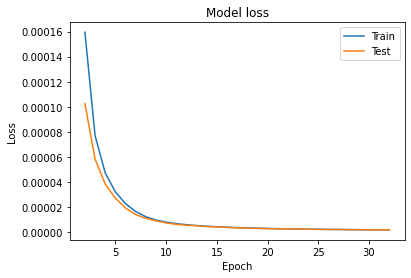

In [31]:
plot_loss(final_hist['loss'][2:], final_hist['val_loss'][2:])

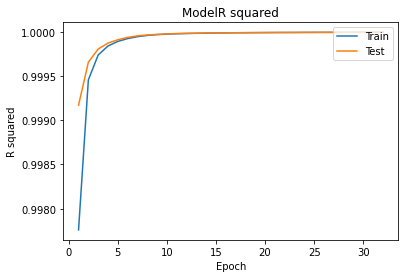

In [32]:
plot_metr(final_hist['r_square'][1:], \
          final_hist['val_r_square'][1:], 'R squared')

## Last fit with 200 epochs

In [37]:
trained_200 = final_model_arch.fit(X_train,y_train,epochs=200,validation_split=0.2,callbacks=[callbacks],
                           batch_size = output['batch_size'])

Epoch 1/200


2022-05-08 08:52:57.642086: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1250/1250 [==============================] - 19s 15ms/step - loss: 0.1460 - r_square: 0.5013 - val_loss: 0.0049 - val_r_square: 0.9836
Epoch 2/200
1250/1250 [==============================] - 19s 15ms/step - loss: 0.0013 - r_square: 0.9956 - val_loss: 3.3786e-04 - val_r_square: 0.9989
Epoch 3/200
1250/1250 [==============================] - 19s 15ms/step - loss: 1.9893e-04 - r_square: 0.9993 - val_loss: 1.2065e-04 - val_r_square: 0.9996
Epoch 4/200
1250/1250 [==============================] - 19s 15ms/step - loss: 8.6965e-05 - r_square: 0.9997 - val_loss: 6.3821e-05 - val_r_square: 0.9998
Epoch 5/200
1250/1250 [==============================] - 19s 15ms/step - loss: 4.9410e-05 - r_square: 0.9998 - val_loss: 3.9469e-05 - val_r_square: 0.9999
Epoch 6/200
1250/1250 [==============================] - 19s 15ms/step - loss: 3.2030e-05 - r_square: 0.9999 - val_loss: 2.6760e-05 - val_r_square: 0.9999
Epoch 7/200
1250/1250 [==============================] - 19s 15ms/step - loss: 2.2092e-05 - r_

Epoch 54/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0526e-06 - r_square: 1.0000 - val_loss: 1.0338e-06 - val_r_square: 1.0000
Epoch 55/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0501e-06 - r_square: 1.0000 - val_loss: 1.0586e-06 - val_r_square: 1.0000
Epoch 56/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0235e-06 - r_square: 1.0000 - val_loss: 1.0467e-06 - val_r_square: 1.0000
Epoch 57/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0146e-06 - r_square: 1.0000 - val_loss: 1.0548e-06 - val_r_square: 1.0000
Epoch 58/200
1250/1250 [==============================] - 20s 16ms/step - loss: 1.0028e-06 - r_square: 1.0000 - val_loss: 9.9042e-07 - val_r_square: 1.0000
Epoch 59/200
1250/1250 [==============================] - 20s 16ms/step - loss: 9.8053e-07 - r_square: 1.0000 - val_loss: 9.6899e-07 - val_r_square: 1.0000
Epoch 60/200
1250/1250 [==============================] - 20s 16

1250/1250 [==============================] - 19s 15ms/step - loss: 4.6409e-07 - r_square: 1.0000 - val_loss: 4.8182e-07 - val_r_square: 1.0000
Epoch 159/200
1250/1250 [==============================] - 19s 16ms/step - loss: 4.6872e-07 - r_square: 1.0000 - val_loss: 4.4620e-07 - val_r_square: 1.0000
Epoch 160/200
1250/1250 [==============================] - 19s 15ms/step - loss: 4.6845e-07 - r_square: 1.0000 - val_loss: 4.6138e-07 - val_r_square: 1.0000
Epoch 161/200
1250/1250 [==============================] - 19s 15ms/step - loss: 4.6722e-07 - r_square: 1.0000 - val_loss: 4.4997e-07 - val_r_square: 1.0000
Epoch 162/200
1250/1250 [==============================] - 19s 15ms/step - loss: 4.5816e-07 - r_square: 1.0000 - val_loss: 5.3716e-07 - val_r_square: 1.0000
Epoch 163/200
1250/1250 [==============================] - 20s 16ms/step - loss: 4.5935e-07 - r_square: 1.0000 - val_loss: 4.8378e-07 - val_r_square: 1.0000
Epoch 164/200
1250/1250 [==============================] - 19s 15ms/step

In [39]:
# serialize model to JSON
model_json_good = final_model_arch.to_json()
with open("results/200epochs_results/model_200_epochs.json", "w") as json_file:
    json_file.write(model_json_good)
# serialize weights to HDF5
final_model_arch.save_weights("results/200epochs_results/model_200_epochs.h5")
print("Saved model to disk")

Saved model to disk


In [44]:
model_hist_good = final_model_arch.history
train_hist_good = pd.DataFrame(model_hist_good.history)
train_hist_good.to_csv('results/200epochs_results/train_hist_200.csv', index=False)